# Necessary imports

In [2]:
!pip install -r requirements.txt

In [3]:
import os

import emoji
import keras
import random
import warnings
import numpy as np
import pandas as pd
import keras.backend
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_nlp.models import DebertaV3Preprocessor, DebertaV3Classifier
import time
import csv
from langdetect import detect

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# Reproducability
keras.utils.set_random_seed(101)

# Mixed precision

In [6]:
keras.mixed_precision.set_global_policy("mixed_float16")

# Importing the dataframe

In [7]:
# Reading in the dataframe
filepath = 'netflix_reviews.csv'
df = pd.read_csv(filepath)
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,5add6ea9-7861-4994-b514-e064c1320e4e,Dennis Smith,❤️,5,0,9.17.1 build 4 62728,2025-06-10 12:54:36,9.17.1 build 4 62728
1,46ce3e8a-51d6-445f-9792-daf29dcda5f1,Teniola Aderibigbe,I wish there was Julie and the phantoms season 2,4,0,9.18.2 build 10 62780,2025-06-10 12:35:39,9.18.2 build 10 62780
2,4a7e91e0-9feb-47e7-9cbf-63e612e8fb44,Shazwan Shafie (Dio92),I can't stop watching Netflix... really enjoye...,5,0,9.18.2 build 10 62780,2025-06-10 12:25:50,9.18.2 build 10 62780
3,359b680f-2507-4b9c-9027-f5c4142f6ce9,Prince Chibueyi,Love it so much,5,0,8.143.5 build 19 52400,2025-06-10 12:19:21,8.143.5 build 19 52400
4,d396b4e3-7906-483e-a6c4-c38754f66c97,Katleho Stuurman,best app ever,5,0,9.18.2 build 10 62780,2025-06-10 12:16:35,9.18.2 build 10 62780
...,...,...,...,...,...,...,...,...
137841,a760ead9-e7aa-4ed1-a651-5c37c3600dac,A Google user,i really like it! there are so many movies and...,5,0,NaN,2019-08-03 15:06:03,NaN
137842,4957f9e7-d7f4-4a52-9764-031cebcac83f,Captain Jeoy,I love Netflix. I always enjoy my time using it.,5,0,8.34.0 build 4 50250,2022-08-15 16:16:30,8.34.0 build 4 50250
137843,9acf7586-7abf-4b50-8c50-3ede3b2a42c4,Suryansh,Sound quality is very slow of movies,1,0,NaN,2020-08-17 07:26:58,NaN
137844,32870f7f-c461-4256-b602-75244ca60248,A Google user,Rate is very expensive.. bcos we see netflix s...,1,0,7.17.0 build 13 34346,2019-07-21 09:41:42,7.17.0 build 13 34346


All the columns of our dataframe are not important for the purpose of sentiment analysis. And the columns that are useful to us are not in proper format. So we will apply the following preprocessing to our dataframe:

* Drop all the columns from the dataframe except for 'content' and 'score'
* Change the data type of the 'content' column to str and the rest of the columns to int
* Create a new column called 'sentiment' which will have the value 1 (positive) if the corresponding score is >= 3, else it will have the value 0 (negative)

In [8]:
df = df.drop(df.columns[[0, 1, 4, 5, 6, 7]], axis=1) # dropping all the columns except for 'content' and 'score'
df[df.columns[0]] = df[df.columns[0]].astype(str) # changing the datatype of 'content' column to str
df[df.columns[1:]] = df[df.columns[1:]].astype(int) # changing the datatype of all other columns to int

def score_to_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

# Apply function 
df['sentiment'] = df['score'].apply(score_to_sentiment)

df

,content,score,sentiment
0,❤️,5,positive
1,I wish there was Julie and the phantoms season 2,4,positive
2,I can't stop watching Netflix... really enjoye...,5,positive
3,Love it so much,5,positive
4,best app ever,5,positive
...,...,...,...
137841,i really like it! there are so many movies and...,5,positive
137842,I love Netflix. I always enjoy my time using it.,5,positive
137843,Sound quality is very slow of movies,1,negative
137844,Rate is very expensive.. bcos we see netflix s...,1,negative


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137846 entries, 0 to 137845
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   content    137846 non-null  object
 1   score      137846 non-null  int64 
 2   sentiment  137846 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.2+ MB


# Data pre-processing

In [10]:
def de_emojize_text(text):
    for x in text: # If a text contains an emoji, convert that emoji into its english name
        if emoji.is_emoji(x):
            demojized = emoji.demojize(x).split("_")
            demojized_string = " ".join(demojized)
            text = text.replace(x, demojized_string)
    return text

In [11]:
df['content'] = df['content'].apply(de_emojize_text)

In [12]:
df[df['content'].apply(lambda x: all(emoji.is_emoji(char) for char in x))]

,content,score,sentiment


In [13]:
# Convert sentiments to numerical labels
sentiment_label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['sentiment'].map(sentiment_label_map).values

In [14]:
# Detect language of the text
def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'error'
df['language'] = (
    df['content'].astype(str).apply(detect_lang)
)

In [15]:
# Filter out non-English reviews
df = df[df['language'] == 'en']

# Reset index after filtering
df.reset_index(drop=True, inplace=True)

df.head()

,content,score,sentiment,language
0,:red heart:️,5,2,en
1,I wish there was Julie and the phantoms season 2,4,2,en
2,I can't stop watching Netflix... really enjoye...,5,2,en
3,Love it so much,5,2,en
4,It's has experienced sublime quality to watch ...,5,2,en


In [14]:
# DeBERTaV3 preprocessor
preprocessor = DebertaV3Preprocessor.from_preset(
    preset="deberta_v3_extra_small_en",
    sequence_length=30 # average length of reviews
)

I0000 00:00:1749780714.503090    6210 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4599 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [15]:
def preprocess_fn(text, label):
    tokens = preprocessor(text)
    return {
        "token_ids": tokens["token_ids"],
        "padding_mask": tokens["padding_mask"]
    }, label


# Train-Validation-Test split

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(df['content'],
                                                      df['sentiment'],
                                                      test_size=0.1,
                                                      random_state=101)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid,
                                                    y_valid,
                                                    test_size=0.5,
                                                    random_state=101)

# Building tensorflow dataset

In [17]:
def build_tf_dataset(features, labels, BATCH_SIZE):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False

    reviews = tf.convert_to_tensor(features.tolist(), dtype=tf.string)
    sentiments = tf.convert_to_tensor(labels.tolist(), dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((reviews, sentiments))
    dataset = dataset.map(preprocess_fn, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(1024, seed=101)
    dataset = dataset.with_options(options)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTO)

    return dataset


In [18]:
BATCH_SIZE = 4

train_dataset = build_tf_dataset(X_train, y_train, BATCH_SIZE)
valid_dataset = build_tf_dataset(X_valid, y_valid, BATCH_SIZE)
test_dataset = build_tf_dataset(X_test, y_test, BATCH_SIZE)

2025-06-13 09:11:56.187624: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:40] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /opt/cuda
  /home/barun/mundi/ml/fp/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/barun/mundi/ml/fp/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/barun/mundi/ml/fp/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda
  /home/barun/mundi/ml/fp/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../..
  /home/barun/mundi/ml/fp/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../..
  .
You c

In [19]:
for batch in train_dataset.take(1):
    x, y = batch
    print("Keys:", x.keys())  # Should print: dict_keys(['token_ids', 'padding_mask'])
    print("token_ids shape:", x['token_ids'].shape)  # (batch_size, 30)
    print("padding_mask shape:", x['padding_mask'].shape)  # (batch_size, 30)
    print("Labels shape:", y.shape)  # (batch_size,)


Keys: dict_keys(['token_ids', 'padding_mask'])
token_ids shape: (4, 30)
padding_mask shape: (4, 30)
Labels shape: (4,)


2025-06-13 09:11:58.985019: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Modelling

In [ ]:
# Prepare CSV logging
log_filename = 'bert_models_tuning/bert_fine_tuning_result.csv'
fieldnames = ['run_id', 'optimizer', 'learning_rate', 'batch_size', 'activation',
              'val_accuracy', 'val_loss', 'train_time_sec']
os.makedirs('bert_models_tuning', exist_ok=True)

In [21]:
# Early stopping
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min',
    min_delta=0.01,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
def run_training(opt, lr, act, run_id):
    with open(log_filename, mode='a', newline='') as log_file:
        writer = csv.DictWriter(log_file, fieldnames=fieldnames)

        run_id = run_id
        print(f"\n🔧 Run {run_id}: Optimizer={opt}, LR={lr}, Activation={act}")

        # Initialize model
        classifier = DebertaV3Classifier.from_preset(
            "deberta_v3_extra_small_en",
            preprocessor=None,
            activation=act,
            num_classes=3
        )

        # Optimizer
        optimizer_class = tf.keras.optimizers.AdamW if opt == 'adamw' else tf.keras.optimizers.Adam

        # Compile
        classifier.compile(
            optimizer=optimizer_class(learning_rate=lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
        )

        # Train
        start_time = time.time()
        history = classifier.fit(
            train_dataset,
            validation_data=valid_dataset,
            epochs=num_epochs,
            callbacks=[earlystopping],
            verbose=2
        )
        end_time = time.time()
        duration = end_time - start_time

        # Metrics
        val_accuracy = max(history.history['val_accuracy'], default=None)
        val_loss = min(history.history['val_loss'], default=None)

        # Save model
        model_path = f'bert_models_tuning/run_{run_id}_valacc_{val_accuracy:.4f}.keras'
        classifier.save(model_path)

        # Log results
        writer.writerow({
            'run_id': run_id,
            'optimizer': opt,
            'learning_rate': lr,
            'activation': act,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'train_time_sec': round(duration, 2)
        })
        log_file.flush()
        keras.backend.clear_session()

In [23]:
# Define hyperparameter search space
learning_rates = [5e-5, 3e-5, 1e-5]
optimizers = ['adamw', 'adam']
activations = ['softmax']
num_epochs = 5

In [24]:
#run_training(optimizers[0], learning_rates[0], activations[0], 1)

In [25]:
#run_training(optimizers[1], learning_rates[0], activations[0], 2)

In [26]:
#run_training(optimizers[0], learning_rates[1], activations[0], 3)

In [27]:
#run_training(optimizers[1], learning_rates[1], activations[0], 4)

In [28]:
#run_training(optimizers[0], learning_rates[2], activations[0], 5)

In [29]:
run_training(optimizers[1], learning_rates[2], activations[0], 6)


🔧 Run 6: Optimizer=adam, LR=1e-05, Activation=softmax
Epoch 1/5


I0000 00:00:1749780771.830344    7178 service.cc:152] XLA service 0x7665b401cae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749780771.830361    7178 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-06-13 09:12:54.443584: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749780783.326385    7178 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1749780833.524756    7178 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-13 09:32:56.445687: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion', 28 bytes spill stores, 28 bytes spill loads



31016/31016 - 1281s - 41ms/step - accuracy: 0.8143 - loss: 0.5140 - val_accuracy: 0.8284 - val_loss: 0.4731
Epoch 2/5
31016/31016 - 1171s - 38ms/step - accuracy: 0.8325 - loss: 0.4620 - val_accuracy: 0.8281 - val_loss: 0.4860
Epoch 3/5
31016/31016 - 1123s - 36ms/step - accuracy: 0.8432 - loss: 0.4295 - val_accuracy: 0.8304 - val_loss: 0.4669
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


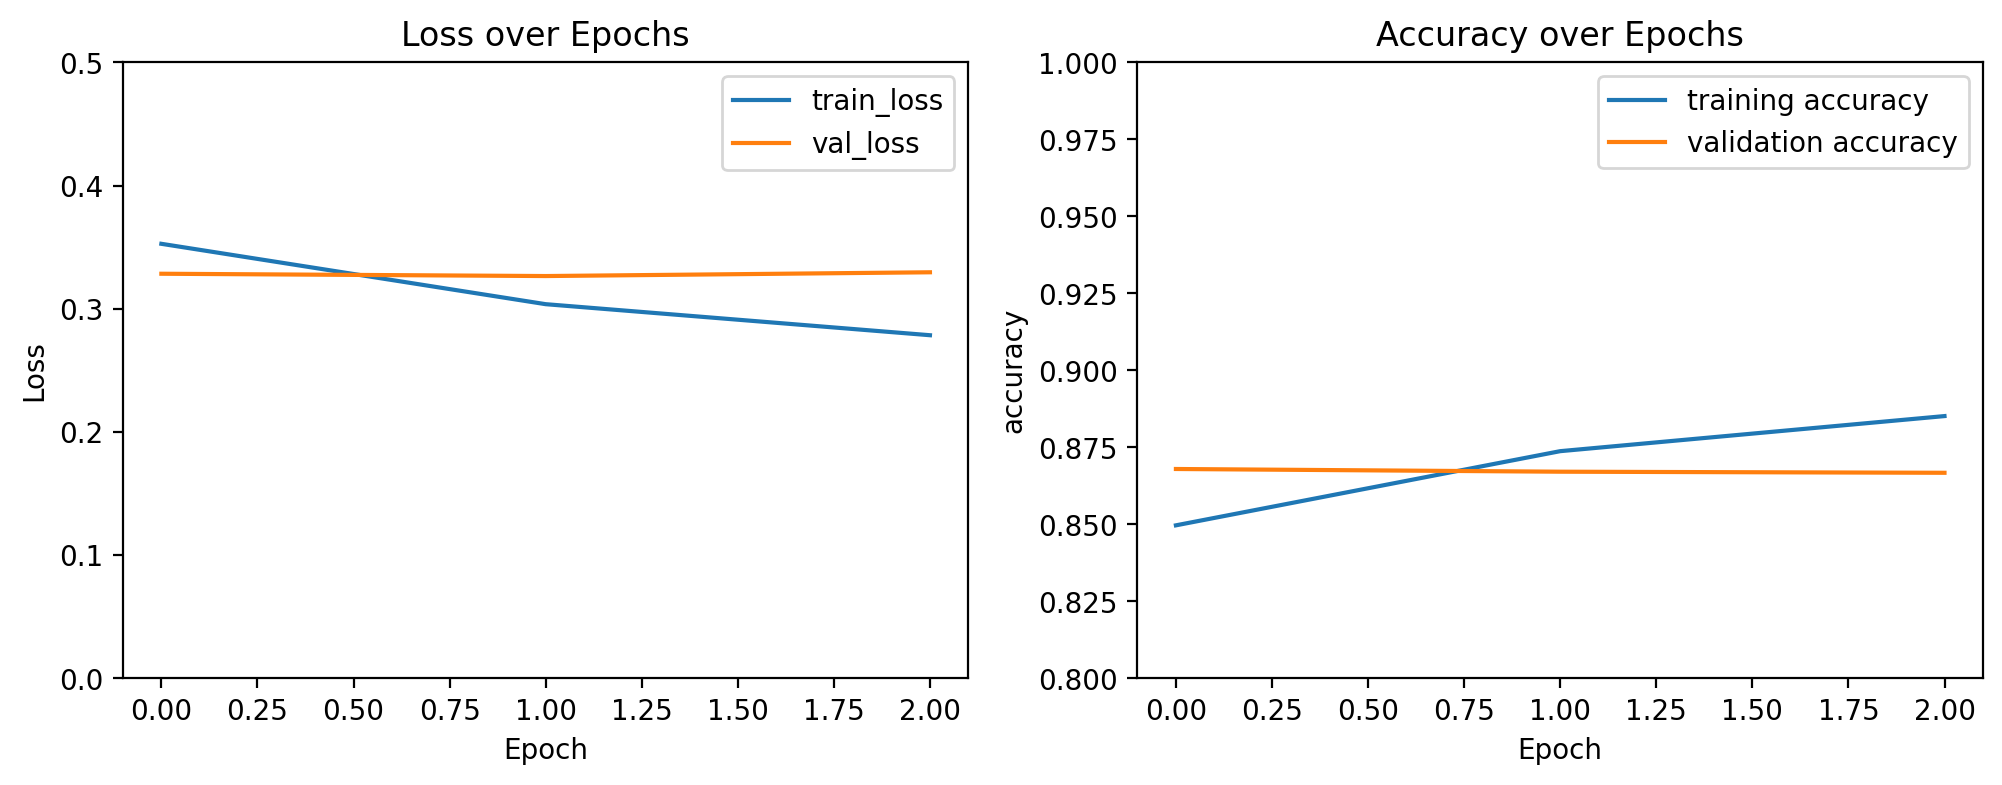

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim(0, 0.5)
plt.yticks([i * 0.1 for i in range(6)])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.ylim(0.8, 1)
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show();

# Model evaluation

In [ ]:
test_loss, test_accuracy = classifier.evaluate(test_dataset)
print(f"The model loss on the test dataset is {round(test_loss, 4)}.")
print(f"The model accuracy on the test dataset is {round(test_accuracy, 4)*100}%.")

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.8611 - loss: 0.3379
The model loss on the test dataset is 0.3394.
The model accuracy on the test dataset is 85.83%.
